# Tune density threshold to get desired DLA / HCD bias 

In [1]:
%pylab inline
# set the size of figures below
pylab.rcParams['figure.figsize'] = (10, 4)
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


We want to compute the threshold needed to get a given bias (with respect to Gaussian field at z=0). 

These notes are based on Font-Ribera & Miralda-Escudé (2012).

We will look at a toy model to describe galaxy bias:
- The distribution of density fluctuations is described by a Gaussian d, with <d>=0 and <d^2>=1
- We choose a density threshold nu, and those cells with d>nu will host a galaxy

In [2]:
show_plot=True
# this sets the threshold 
nu = 1.5
# probability density at the threshold
p_nu = norm.pdf(nu)
# density of galaxies is equal to the fraction of cells with density above the threshold 
mean = 1.0-norm.cdf(nu)
print('mean =',mean)

mean = 0.06680720126885809


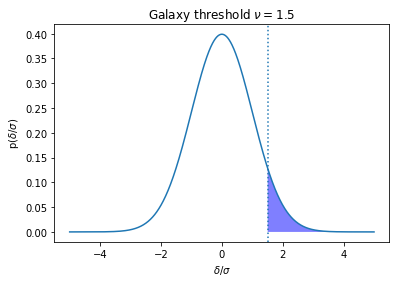

In [3]:
if show_plot:
    d = np.linspace(-5,5,1000)
    pdf = norm.pdf(d)
    plt.plot(d,pdf)
    above=(d>nu)
    plt.fill_between(d[above],0,pdf[above], facecolor='blue', alpha=0.5)
    plt.axvline(x=nu,ls=':')
    plt.xlabel('$\\delta/\\sigma$')
    plt.ylabel('p($\\delta/\\sigma$)')
    plt.title('Galaxy threshold $\\nu='+str(nu)+'$')
    plt.savefig('pdf_galaxy.pdf')

### Bias for a given threshold

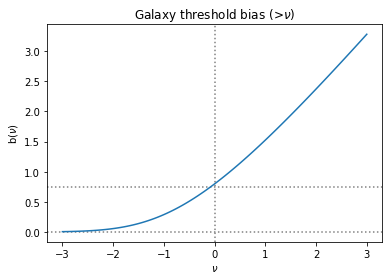

In [4]:
# explore different values of nu
nu=np.linspace(-3,3,100)
# probability density at the threshold
p_nu = norm.pdf(nu)
# density of galaxies is equal to the fraction of cells with density above the threshold 
galaxy_mean = 1.0-norm.cdf(nu)
b_nu = p_nu / galaxy_mean
zoom_plot=False
if show_plot:
    # BOSS measured DLA bias of 2 at z=2.3 or so, what means D(z)*b ~ 0.75
    plt.axhline(y=0.75,ls=':',color='gray') 
    plt.axhline(y=0,ls=':',color='gray')     
    plt.axvline(x=0,ls=':',color='gray') 
    plt.plot(nu,b_nu,label='galaxies')
    if zoom_plot:
        plt.xlim(-1,1)
        plt.ylim(0,2)
    plt.xlabel('$\\nu$')
    plt.ylabel('b($\\nu$)')
    plt.title('Galaxy threshold bias (>$\\nu$)')
    plt.savefig('bias_galaxy.pdf')

### Bias for a given threshold

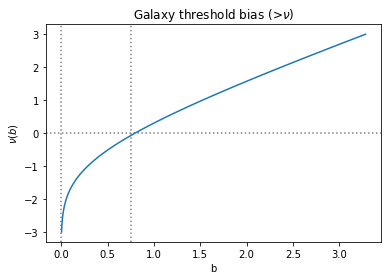

In [5]:
if show_plot:
    # BOSS measured DLA bias of 2 at z=2.3 or so, what means D(z)*b ~ 0.75
    plt.axvline(x=0.75,ls=':',color='gray') 
    plt.axvline(x=0,ls=':',color='gray')     
    plt.axhline(y=0,ls=':',color='gray') 
    plt.plot(b_nu,nu,label='galaxies')
    if zoom_plot:
        plt.ylim(-1,1)
        plt.xlim(0,2)
    plt.ylabel('$\\nu(b)$')
    plt.xlabel('b')
    plt.title('Galaxy threshold bias (>$\\nu$)')
    plt.savefig('galaxy_threshold.pdf')

### Read D(z) from CoLoRe to get nu(z)

In [6]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [7]:
#Open data file (test file with few quasars)
hdulist = fits.open('../example_data/raw_colore_1000/out_srcs_s1_0.fits')
cosmo = hdulist[4].data
ds=cosmo['D']
zs=cosmo['Z']

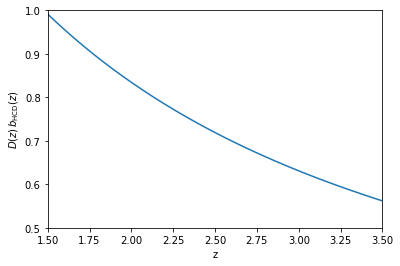

In [8]:
dla_bias=2.0
bDz=ds*dla_bias
plt.plot(zs,bDz)
plt.xlim(1.5,3.5)
plt.ylim(0.5,1.0)
plt.xlabel('z')
plt.ylabel(r'$D(z) \, b_{\rm{HCD}}(z)$')
plt.savefig('dla_bias_z.pdf')

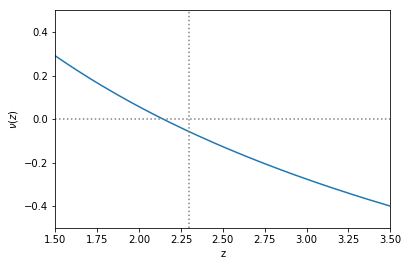

In [9]:
nu_z = np.interp(bDz,b_nu,nu)
plt.plot(zs,nu_z)
plt.xlim(1.5,3.5)
plt.ylim(-0.5,0.5)
plt.xlabel('z')
plt.ylabel(r'$\nu(z)$')
plt.axvline(x=2.3,ls=':',color='gray')     
plt.axhline(y=0,ls=':',color='gray') 
plt.savefig('dla_threshold_z.pdf')